In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from functools import partial

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model

from sklearn import preprocessing
from scipy.optimize import minimize

pd.set_option('display.max_columns', None)

# custom modules
from preproc import load_data,scale_data
#from calibration1 import calibrate_probs,optimize_calibration
from calibration2 import calibrate_probs,optimize_calibration

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
np.random.seed(2112)
tf.random.set_seed(2112)

***
## loading data

In [3]:
train,test,input_cols = load_data()

display(train)
display(test)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train,test,scaler = scale_data(train, test, input_cols)

display(train)
display(test)
scaler

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.033981,0.108373,0.044605,0.035517,0.045482,0.018287,0.002479,0.251779,0.003796,0.077771,0.771084,0.071753,0.443088,0.004597,0.005139,0.020790,0.137333,0.036916,0.024143,0.104796,0.033143,0.022774,0.051444,0.262953,0.561145,0.328451,0.140520,0.006298,0.268041,0.085063,0.258453,0.472186,0.032913,0.069189,0.152195,0.076814,0.108447,0.047387,0.022295,1.0,0.282973,0.073832,0.000589,0.004420,0.006502,0.063036,0.099954,0.052911,0.001397,0.003023,0.083510,0.048493,0.013936,0.272577,0.365256,0.005476,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.023578,0.034117,0.044605,0.058633,0.045482,0.094907,0.002479,0.346863,0.000840,0.103597,0.662651,0.063677,0.042811,0.000286,0.005139,0.013333,0.118135,0.079914,0.030279,0.140320,0.035151,0.367737,0.105660,0.274095,0.580837,0.336605,0.084888,0.006298,0.342784,0.105400,0.232180,0.597566,0.000034,0.069189,0.113041,0.051879,0.046854,0.036744,0.000071,0.0,1.000000,0.089710,0.008039,0.005667,0.000188,0.047373,0.288944,0.001256,0.000399,0.018139,0.068439,0.048493,0.194600,0.358763,0.168059,1.000000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.076283,0.091853,0.044605,0.051324,0.045482,0.175926,0.002479,0.329075,0.000840,0.096791,0.903614,0.052695,0.636367,0.002690,0.005139,0.014336,0.120850,0.135676,0.026753,0.161634,0.033143,0.230403,0.146915,0.203900,0.332596,0.336706,0.152813,0.006298,0.198454,0.114430,0.200682,0.446654,0.007993,0.069189,0.241944,0.082285,0.444567,0.049401,0.008861,1.0,1.000000,0.073832,0.000829,0.073980,0.005540,0.058223,0.324312,0.055894,0.000784,0.038221,0.273070,0.059177,0.095118,0.345063,0.184067,0.008961,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.040915,0.133144,0.062929,0.122300,0.045482,0.096296,0.002479,0.283635,0.000840,0.078583,0.807229,0.096937,0.032063,0.003690,0.005139,0.006693,0.174964,0.139155,0.011682,0.129663,0.044190,0.209258,0.153454,0.145961,0.333693,0.224769,0.093471,0.006298,0.275773,0.133272,0.219385,0.387766,0.016457,0.069189,0.341333,0.077782,0.208095,0.518836,0.014435,1.0,0.290257,0.073832,0.004818,0.019567,0.004994,0.076563,0.414270,0.044385,0.000399,0.009069,0.136466,0.055042,0.014565,0.491913,0.473304,0.007090,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.061720,0.130125,0.044605,0.022368,0.045482,0.103009,0.005313,0.087160,0.069791,0.107966,0.819277,0.132586,0.434411,0.033890,0.005139,0.036194,0.130749,0.114665,0.151954,0.113677,0.033143,0.228034,0.118401,0.167131,0.533393,0.352137,0.095169,0.006298,0.195876,0.093331,0.161965,0.414276,0.007096,0.069189,0.059498,0.077410,0.190497,0.046411,0.003859,1.0,1.000000,0.086494,0.007866,0.009603,0.002708,0.113095,0.381209,0.059109,0.038981,0.003887,0.120847,0.097579,0.059283,0.558809,0.189663,0.004396,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.024272,0.109106,0.064794,0.015089,0.072765,0.091435,0.007497,0.219276,0.001916,0.078357,0.722892,0.068583,0.079176,0.002039,0.005139,0.018213,0.168475,0.087072,0.023787,0.062167,0.037160,0.229712,0.149882,0.216156,0.108966,0.103451,0.169217,0.006298,0.420103,0.168684,0.278689,0.445133,0.000034,0.096021,0.213374,0.084406,0.073911,0.016370,0.000071,0.0,0.473026,0.073832,0.010124,0.009803,0.000188,0.119862,0.275565,0.001256,0.001013,0.002159,0.066041,0.145022,0.056304,0.303414,0.361892,1.000000,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
613,fd895603f071,0.070735,0.190393,

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MaxAbsScaler())])

In [5]:
repeated_cv_split = joblib.load("/kaggle/input/iarc-data-split/repeated_5fold_cv_split_4validation.pkl")
print(len(repeated_cv_split))
# number of repetitions to use
REPETITIONS = 10

10


In [6]:
alpha_labels = ["Alpha_A", "Alpha_B", "Alpha_D", "Alpha_G"]
beta_labels = ["Beta_A","Beta_B","Beta_C"]
gamma_labels = ["Gamma_A","Gamma_B","Gamma_E","Gamma_F","Gamma_G","Gamma_H","Gamma_M","Gamma_N"]
delta_labels = ["Delta_A","Delta_B","Delta_C","Delta_D"]

In [7]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [8]:
# create sample weight column
train["weight"] = 1.
idx = train.query("Class == 1").index
train.loc[idx,"weight"] = scale_pos_weight

***
## training

In [9]:
def create_model_instance(
        hidden_size=64, 
        dropout1=0.1, 
        dropout2=0.05,
        l2_lambda=1e-3,
        label_smoothing=0.01,
        activation="relu",
    ):
    input = tf.keras.Input(shape=(56,))
    x = tf.keras.layers.Dropout(dropout1)(input)
    x = tf.keras.layers.Dense(
        hidden_size, 
        activation=activation, 
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=2112),
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
    )(x)
    x = tf.keras.layers.Dropout(dropout2)(x)
    output1 = Dense(
        4, 
        activation='softmax', 
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=2112),
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
    )(x)
    output2 = Dense(
        3,
        activation='softmax',
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=2112),
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
    )(x)
    output3 = Dense(
        8,
        activation='softmax',
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=2112),
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
    )(x)
    output4 = Dense(
        4, 
        activation='softmax',
        kernel_initializer=tf.keras.initializers.GlorotUniform(seed=2112),
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda),
    )(x)

    model = tf.keras.models.Model(
        inputs=input, 
        outputs=[output1, output2, output3, output4]
    )
    model.compile(
        optimizer='adam',
        loss=[
            tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
            tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
            tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
            tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
        ],
        loss_weights=[1., 1., 1., 1.],
    )
    return model

In [10]:
def balanced_logloss_(y_pred, y_true, eps=1e-7):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, eps, 1-eps)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / (n0+eps)
    log_loss1 = - np.sum(y_true * np.log(p1)) / (n1+eps)
    return (log_loss0 + log_loss1)/2

In [11]:
instance_params = {
    'dropout1': 0.03982678862783072,
    'dropout2': 0.004262334659007105,
    'hidden_size': 448,
    'l2_lambda': 6.67436447730217e-10,
    'label_smoothing': 0.08898495026155208
}

fit_params = {
    'batch_size': 16,
    'epochs': 250,
}

In [12]:
VERBOSE = False

models = list()
metrics = list()
oof_dfs = list()

for repeat in range(REPETITIONS):
    print(f"REPEAT NUMBER: {repeat+1}/{REPETITIONS}")
    cv_split = repeated_cv_split[f"repeat_{repeat}"]
    n_folds = len(cv_split)
    
    oof = train[["Id","Class"]].copy()
    oof["pred_proba"] = np.nan
    
    for split in cv_split:
        fold = split["fold"]
        train_idx = split["train_idx"]
        valid_idx = split["valid_idx"]
        print(f"training model for fold: {fold+1}/{n_folds}")
    
        train_df = train.loc[train_idx,:].reset_index(drop=True)
        valid_df = train.loc[valid_idx,:].reset_index(drop=True)

        model = create_model_instance(**instance_params)
        model.fit(
            x = train_df[input_cols].values, 
            y = [
                train_df[alpha_labels].values, 
                train_df[beta_labels].values, 
                train_df[gamma_labels].values,
                train_df[delta_labels].values,
            ], 
            sample_weight = train_df["weight"].values,
            shuffle = True,
            verbose = 0,
            **fit_params
        )

        out1,_,_,_ = model.predict(valid_df[input_cols].values, verbose=0)
        y_pred = out1[:,1:].sum(axis=1)
        
        valid_loss = balanced_logloss_(y_pred, valid_df.loc[:,"Class"].values)
        oof.loc[valid_idx, "pred_proba"] = y_pred
        
        models.append(model)
        metrics.append(valid_loss)
        
    oof_dfs.append(oof)

REPEAT NUMBER: 1/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUMBER: 2/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUMBER: 3/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUMBER: 4/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUMBER: 5/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUMBER: 6/10
training model for fold: 1/5
training model for fold: 2/5
training model for fold: 3/5
training model for fold: 4/5
training model for fold: 5/5
REPEAT NUM

***
## OOF analysis and calibration

In [13]:
oof_scores = oof_dfs[0].copy()
oof_scores.rename({"pred_proba":"pred_proba0"}, axis=1, inplace=True)

for i in range(1, len(oof_dfs)):
    _df = oof_dfs[i].copy()
    _df.rename({"pred_proba":f"pred_proba{i}"}, axis=1, inplace=True)
    oof_scores = oof_scores.merge(_df, on=["Id","Class"])
    
oof_scores["avg_proba"] = oof_scores.iloc[:,2:].mean(axis=1)
oof_scores

,Id,Class,pred_proba0,pred_proba1,pred_proba2,pred_proba3,pred_proba4,pred_proba5,pred_proba6,pred_proba7,pred_proba8,pred_proba9,avg_proba
0,000ff2bfdfe9,1,0.635440,0.824042,0.860672,0.841867,0.733437,0.910485,0.772707,0.742914,0.839749,0.850378,0.801169
1,007255e47698,0,0.042052,0.049369,0.057624,0.029530,0.062888,0.043786,0.027960,0.074138,0.053859,0.037309,0.047851
2,013f2bd269f5,0,0.497545,0.230958,0.293901,0.406044,0.317062,0.262792,0.302847,0.197744,0.295568,0.435932,0.324039
3,043ac50845d5,0,0.104829,0.041718,0.055494,0.046343,0.026427,0.007987,0.018070,0.024912,0.030584,0.027265,0.038363
4,044fb8a146ec,1,0.683293,0.925636,0.775416,0.741027,0.968777,0.790655,0.646127,0.609473,0.710164,0.741937,0.759250
...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0,0.082426,0.126016,0.122327,0.116165,0.137082,0.155790,0.106729,0.125815,0.183949,0.064742,0.122104
613,fd895603f071,0,0.178084,0.052074,0.157682,0.219283,0.262122,0.238435,0.044114,0.284407,0.218067,0.050300,0.170457
614,fd8ef6377f76,0,0.090307,0.068291,0.078371,0.180764,0.095295,0.226099,0.052748,0.072321,0.156885,0.054053,0.107513
615,fe1942975e40,0,0.274572,0.379488,0.252134,0.364298,0.280876,0.210077,0.434435,0.370824,0.368577,0.174043,0.310932


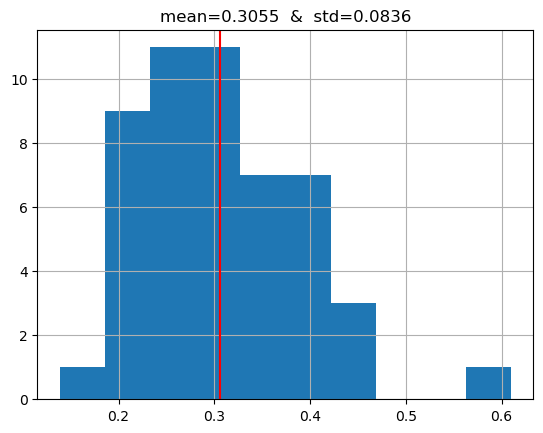

In [14]:
_metrics = metrics[:50]

metric_mean = np.mean(_metrics)
metric_median = np.median(_metrics)
metric_std = np.std(_metrics)

plt.hist(_metrics, bins=10)
plt.axvline(metric_mean, c="r")
plt.title(f"mean={metric_mean:0.4f}  &  std={metric_std:0.4f}")
plt.grid()
plt.show()

In [15]:
calib_params = optimize_calibration(oof_dfs)

best_value: 0.2904142458122567
best_params: {'alpha': 2.117345699271699, 'beta': 1.4891511456958566, 'gamma': 0.580425779181961}


####################################################################################################
CV repeat nbr: 1 - metric: 0.2805


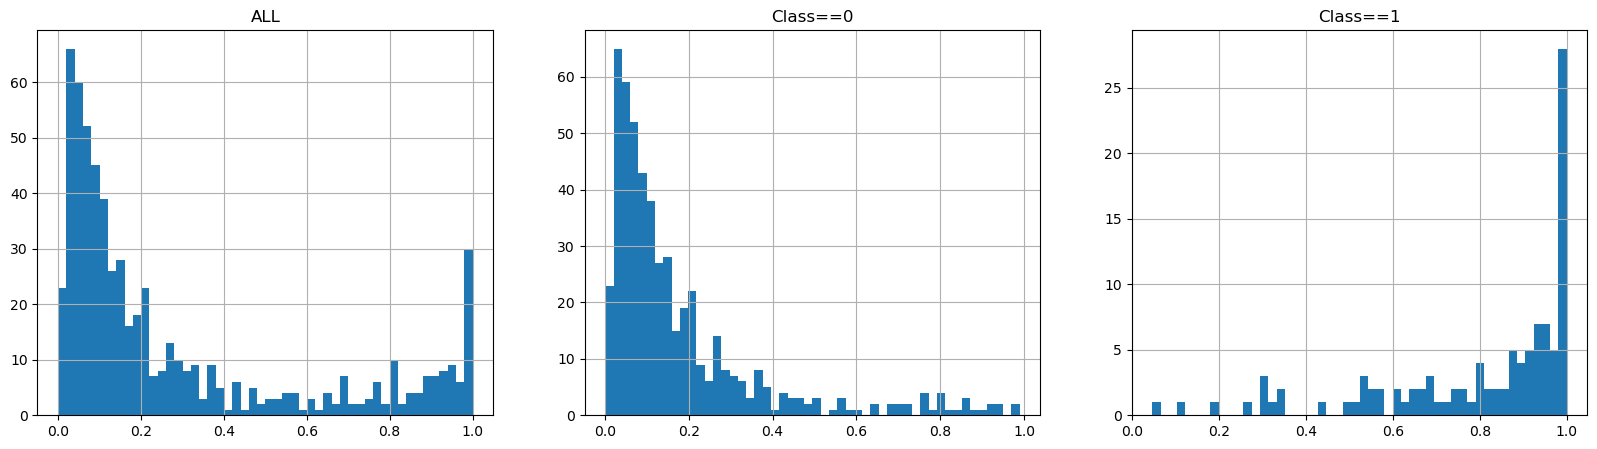

CV repeat nbr: 1 - metric: 0.2629


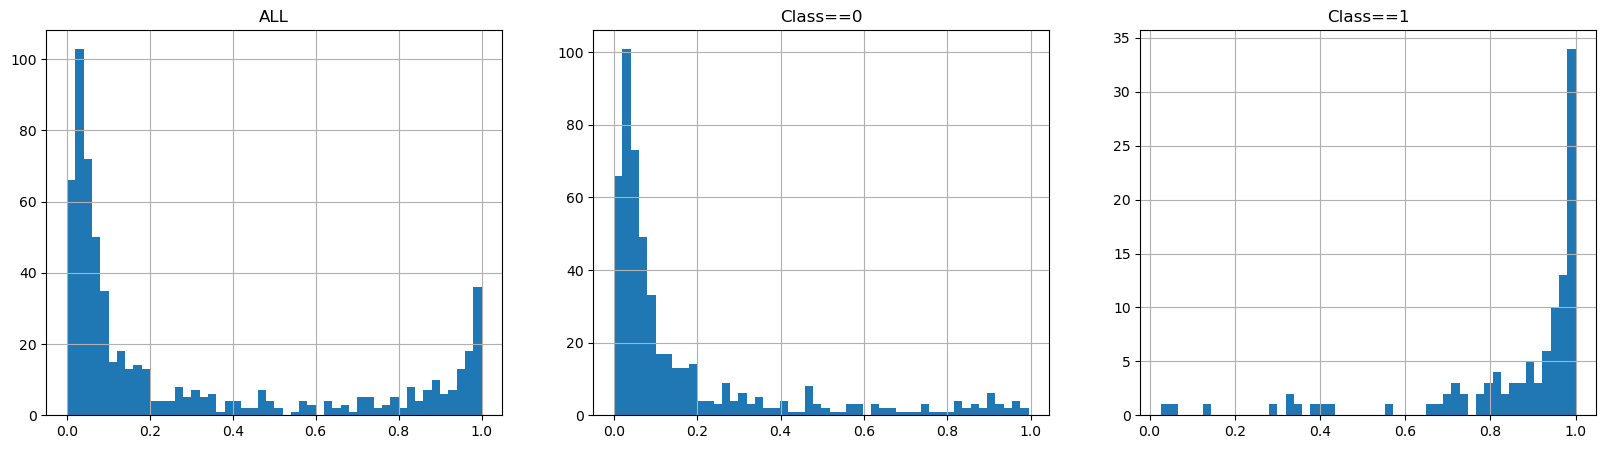

####################################################################################################
CV repeat nbr: 2 - metric: 0.2804


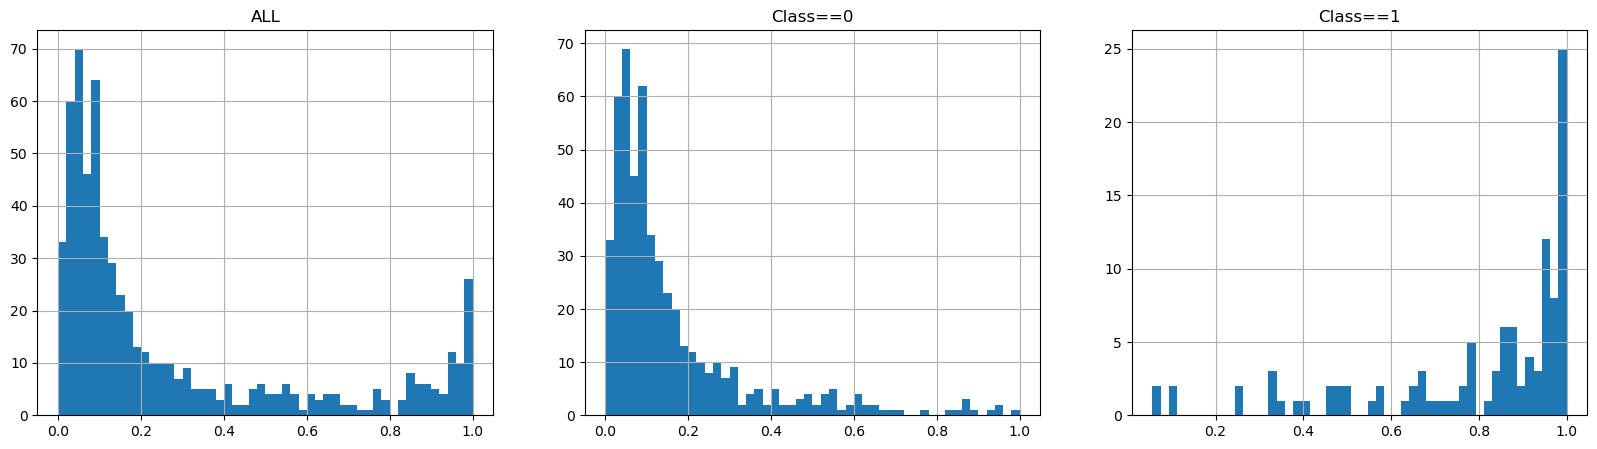

CV repeat nbr: 2 - metric: 0.2647


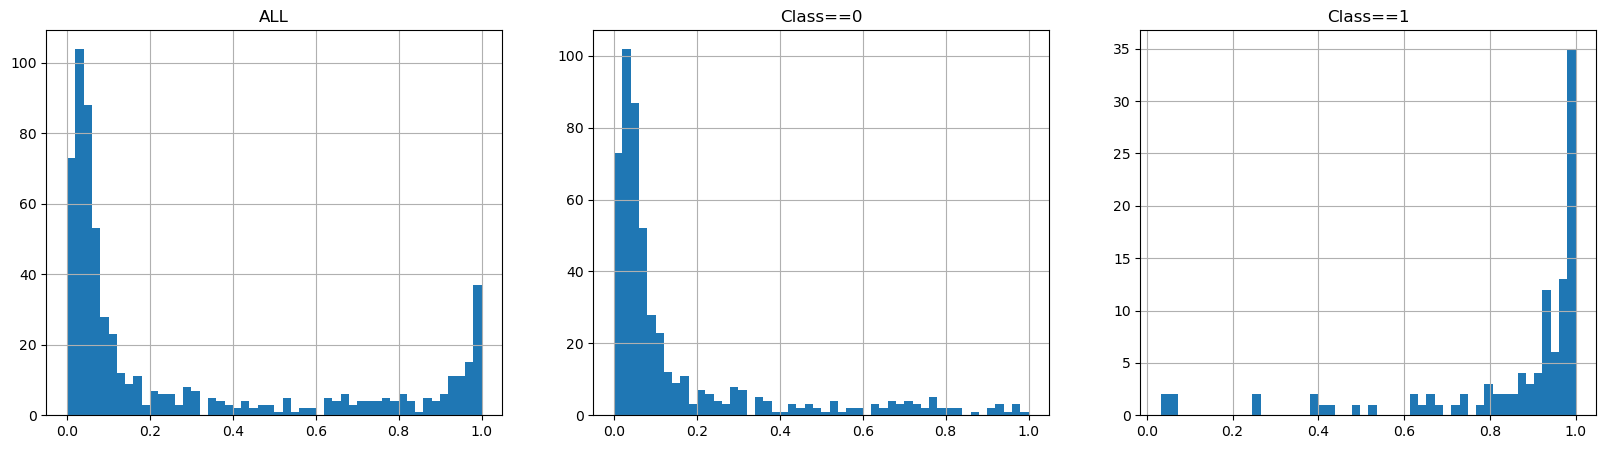

####################################################################################################
CV repeat nbr: 3 - metric: 0.3156


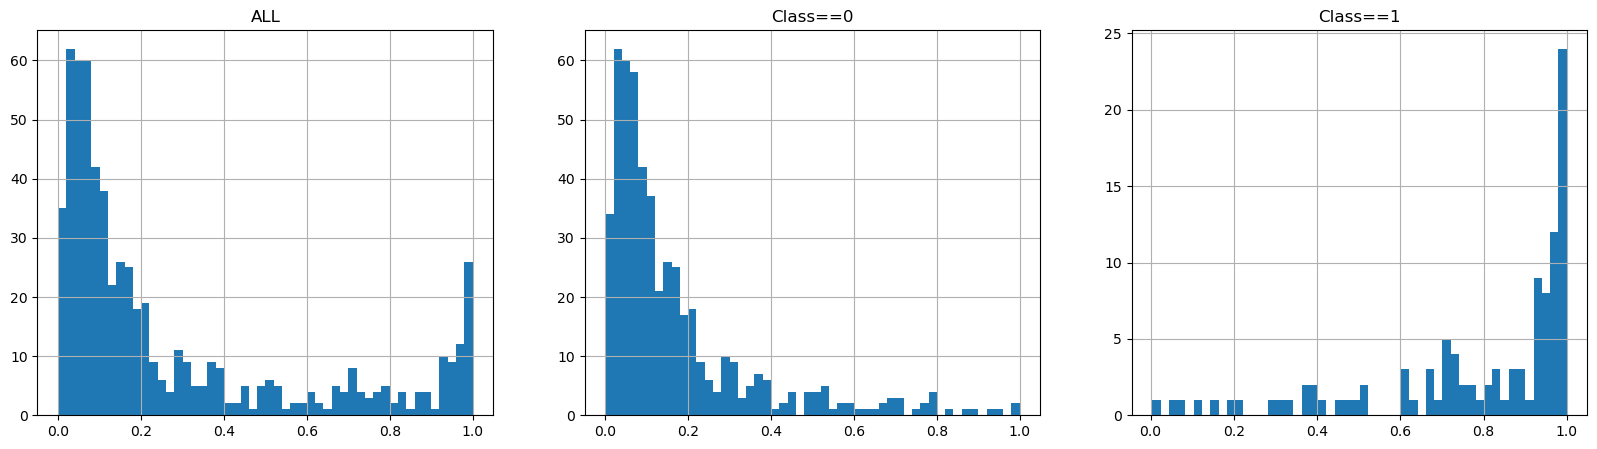

CV repeat nbr: 3 - metric: 0.3050


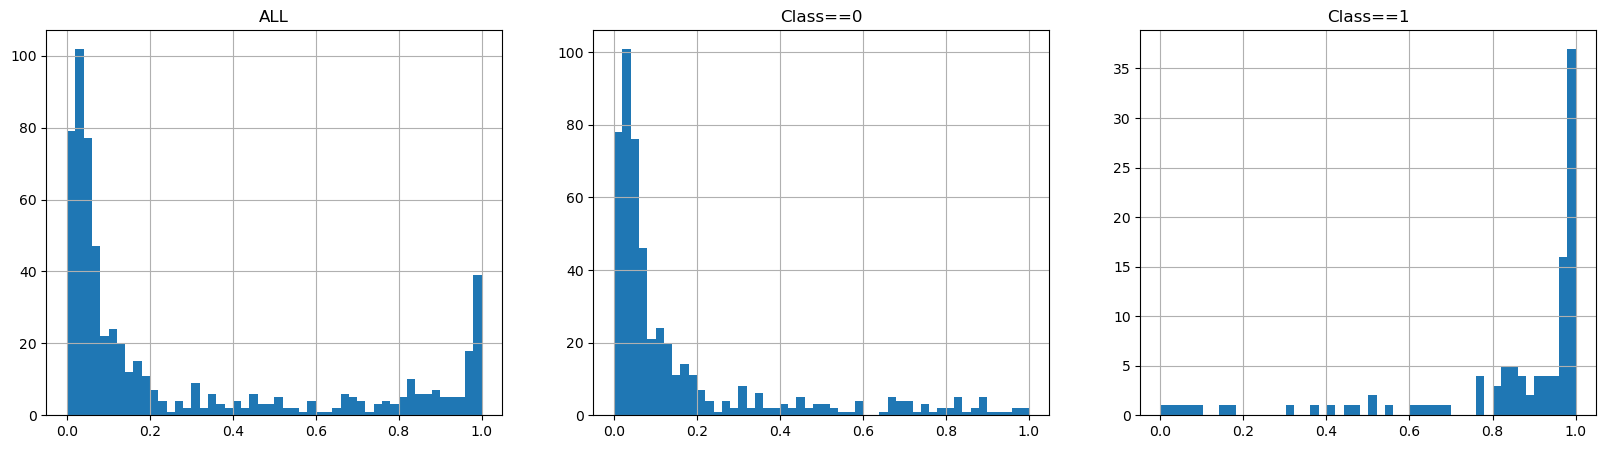

####################################################################################################
CV repeat nbr: 4 - metric: 0.3189


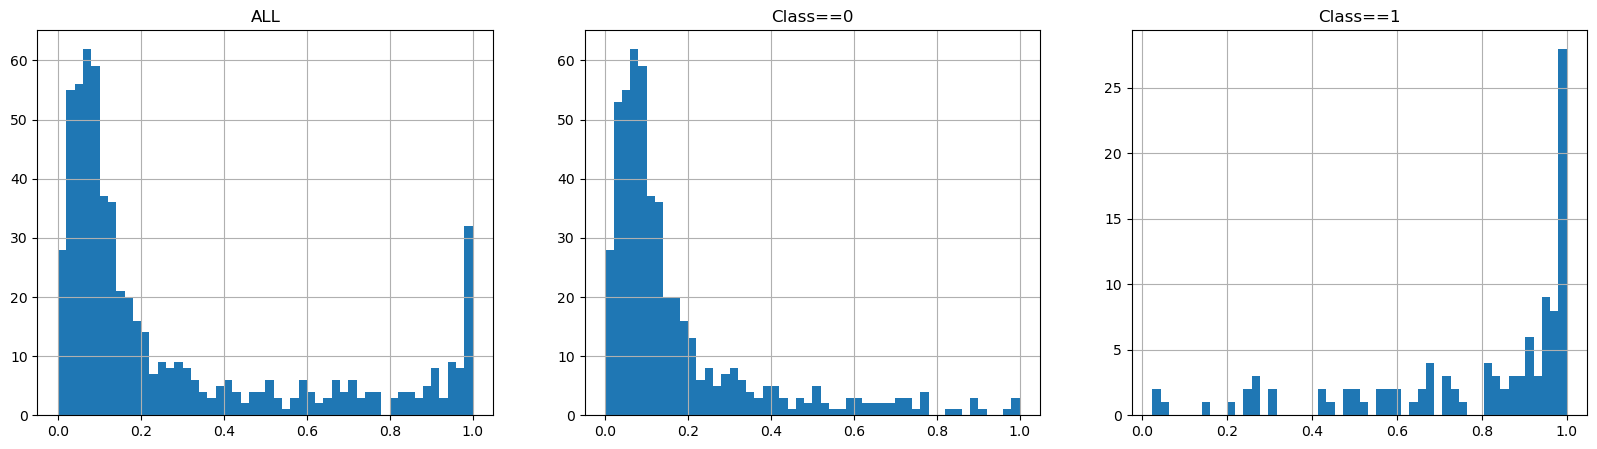

CV repeat nbr: 4 - metric: 0.3096


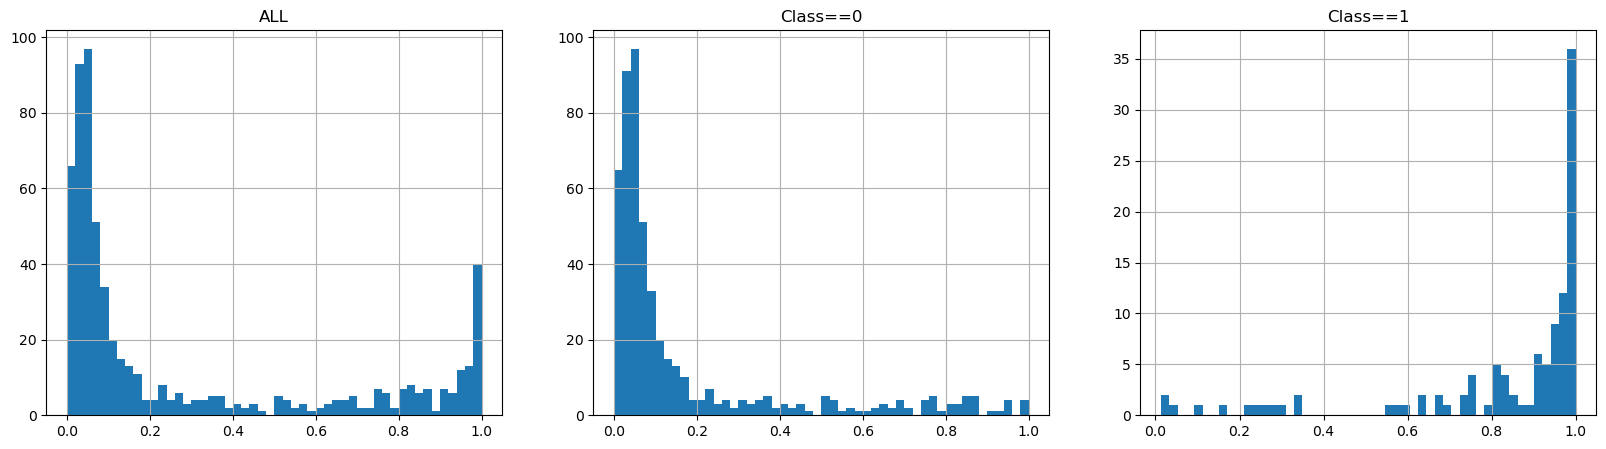

####################################################################################################
CV repeat nbr: 5 - metric: 0.2961


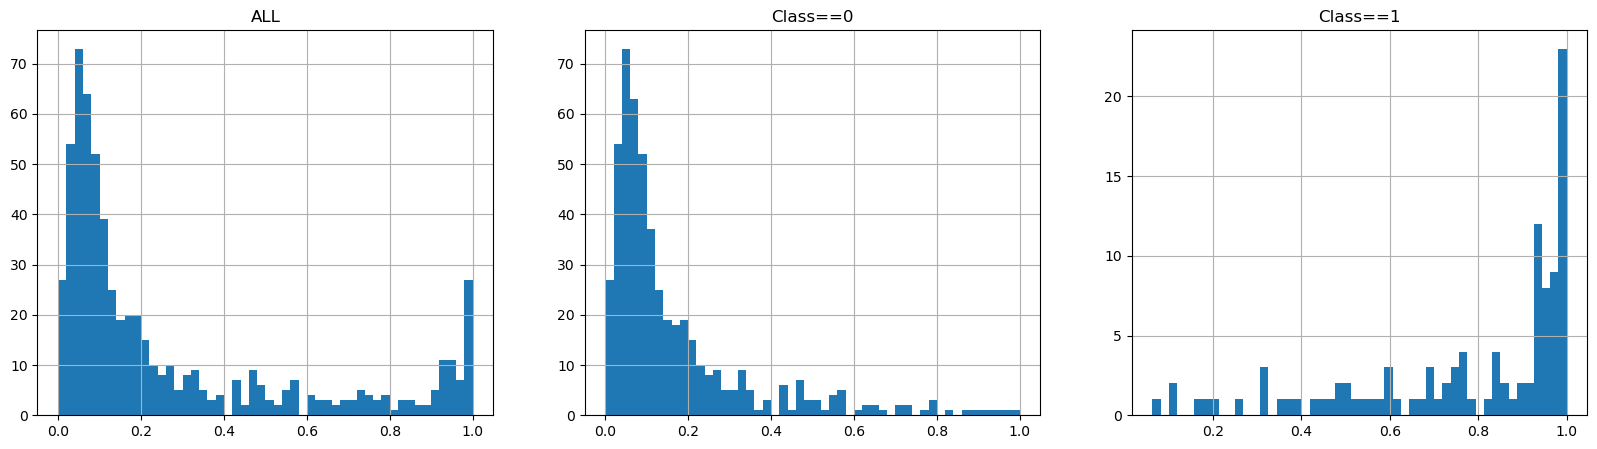

CV repeat nbr: 5 - metric: 0.2786


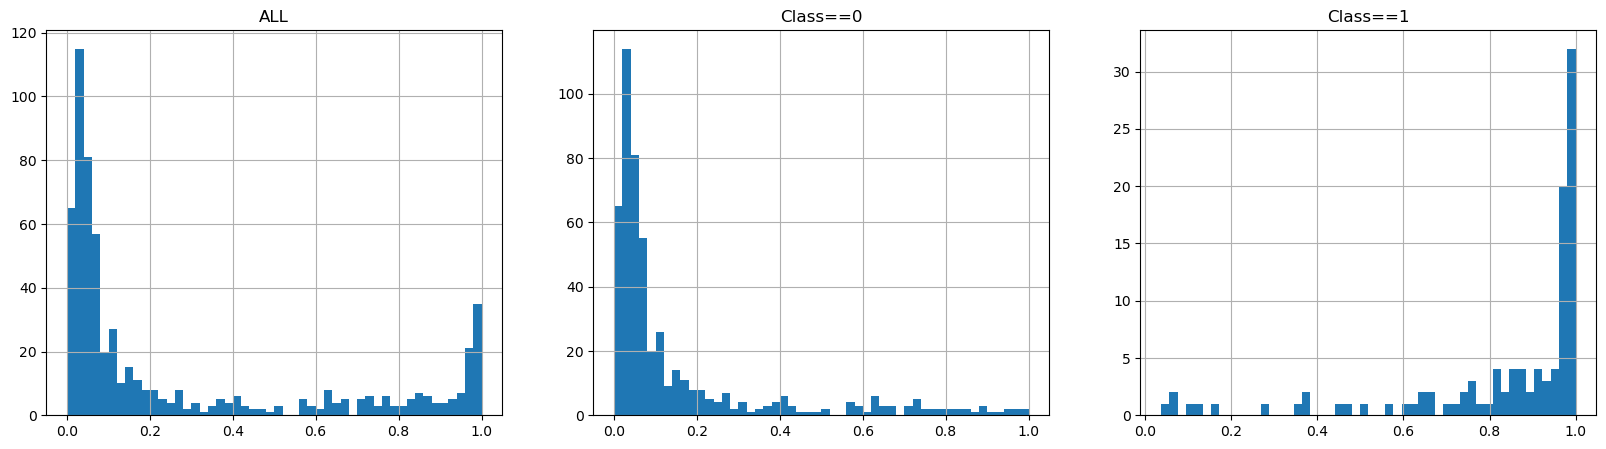

####################################################################################################
CV repeat nbr: 6 - metric: 0.3176


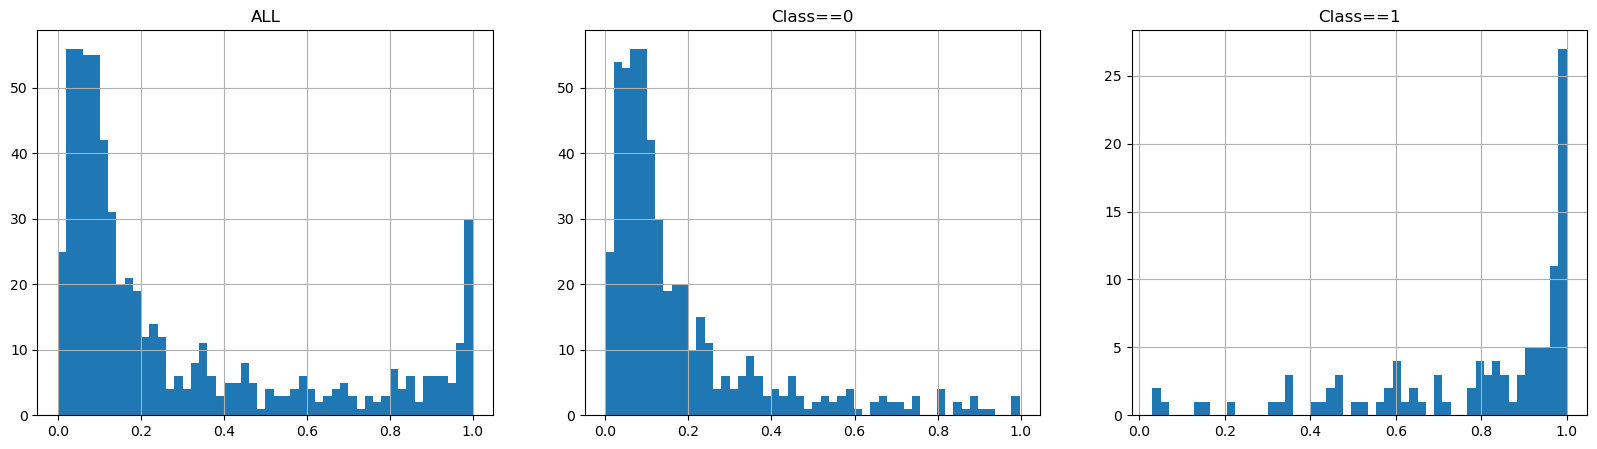

CV repeat nbr: 6 - metric: 0.3062


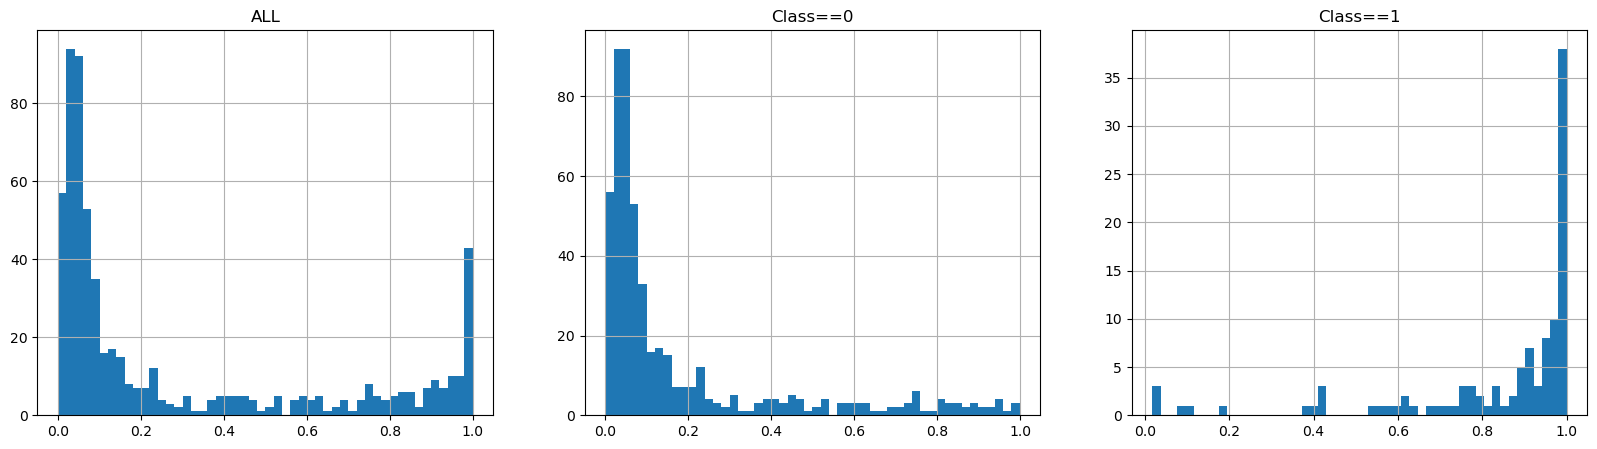

####################################################################################################
CV repeat nbr: 7 - metric: 0.3204


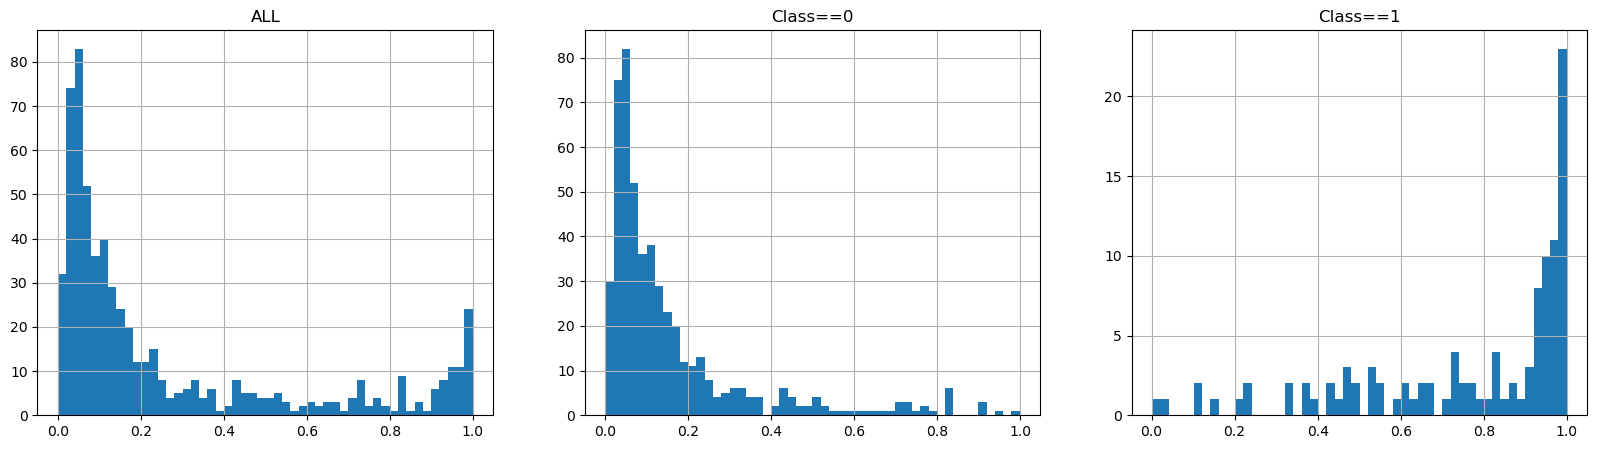

CV repeat nbr: 7 - metric: 0.3032


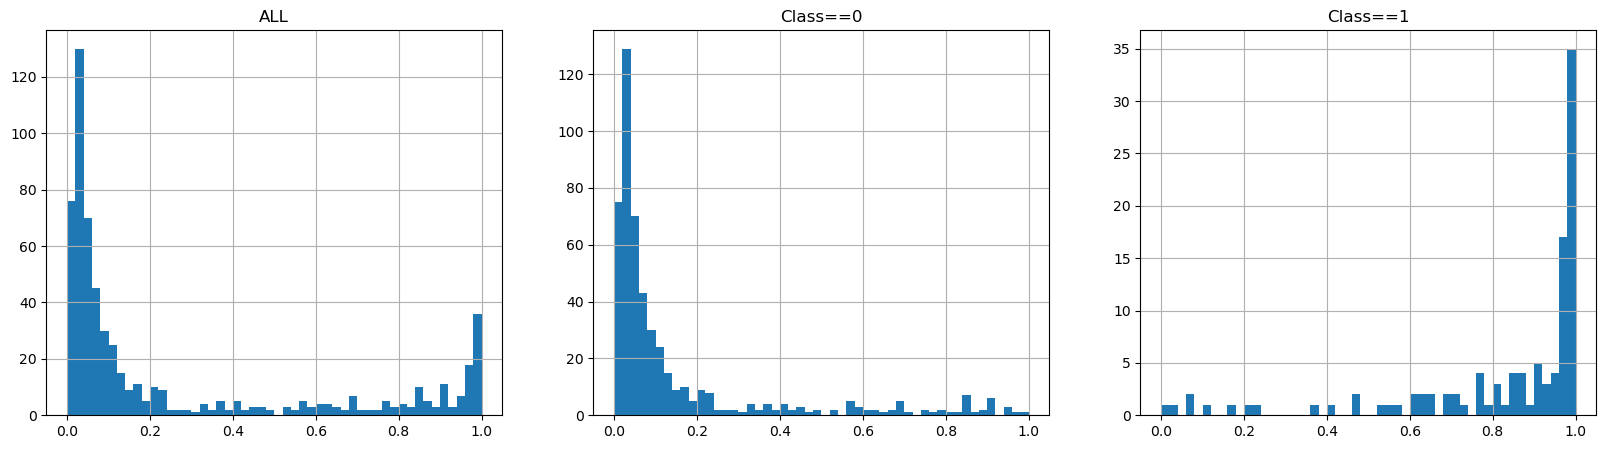

####################################################################################################
CV repeat nbr: 8 - metric: 0.3387


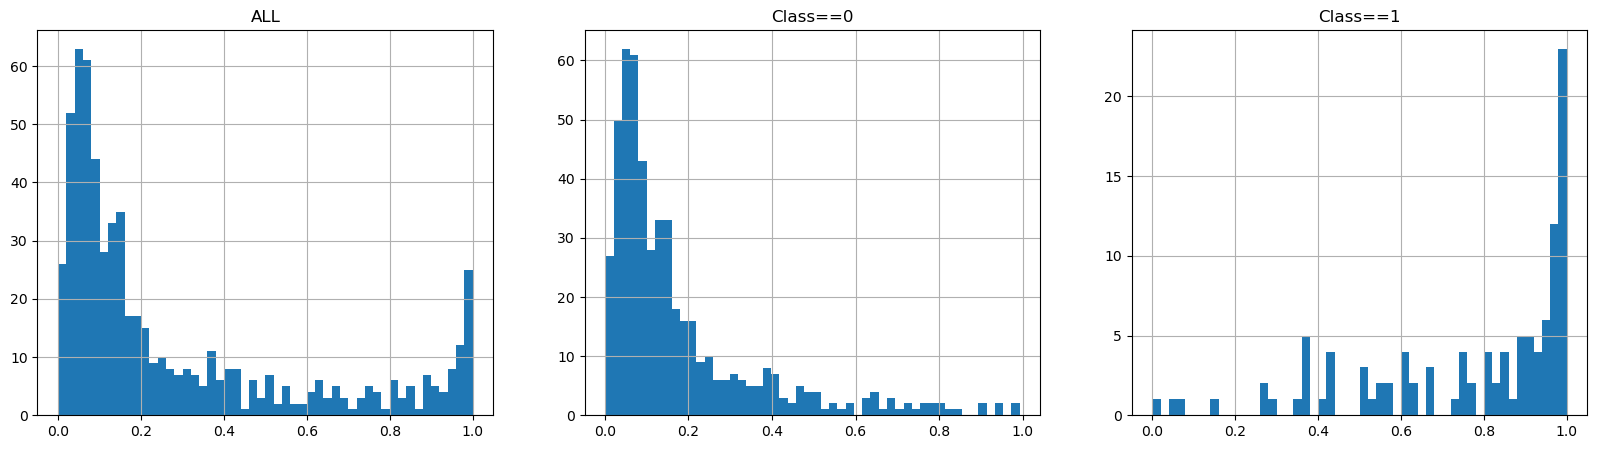

CV repeat nbr: 8 - metric: 0.3203


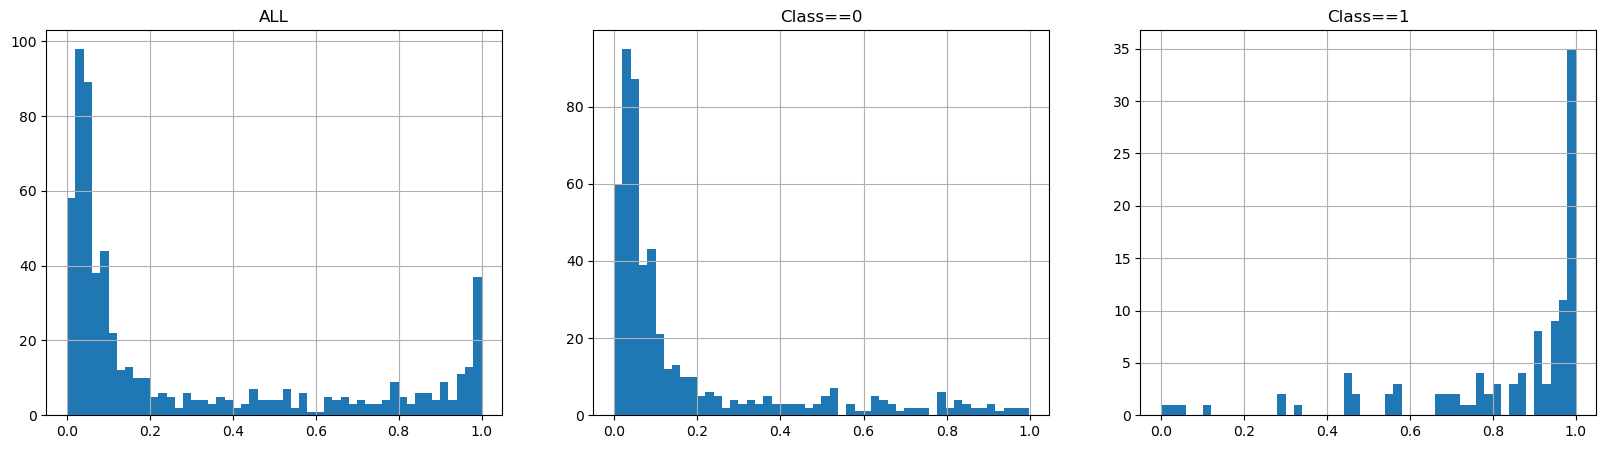

####################################################################################################
CV repeat nbr: 9 - metric: 0.2780


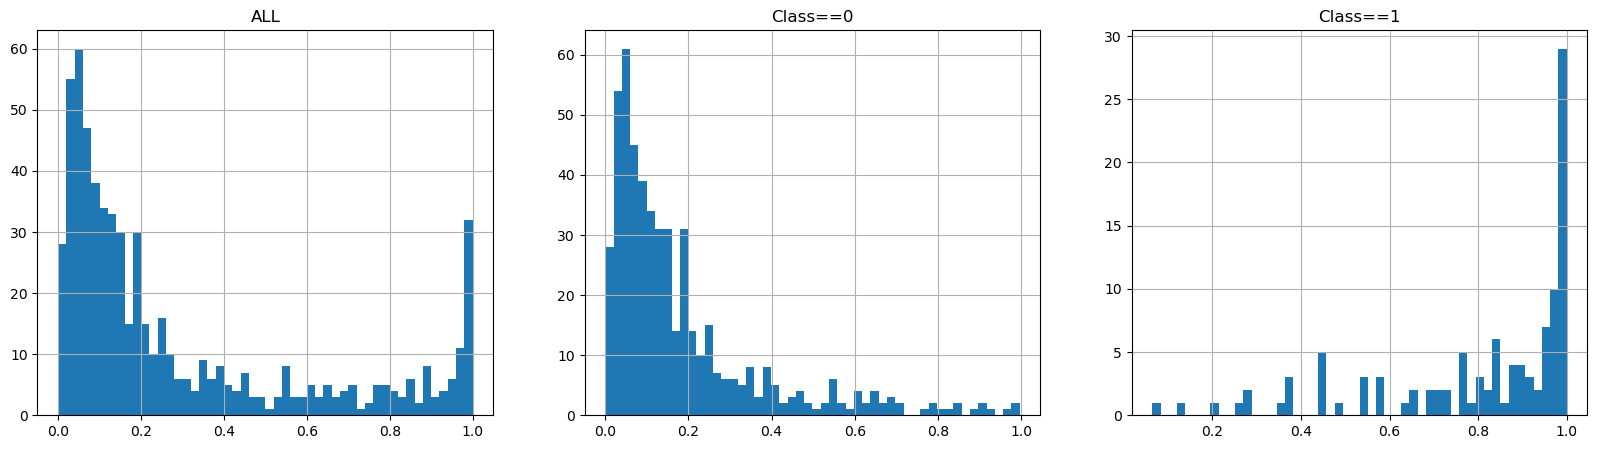

CV repeat nbr: 9 - metric: 0.2617


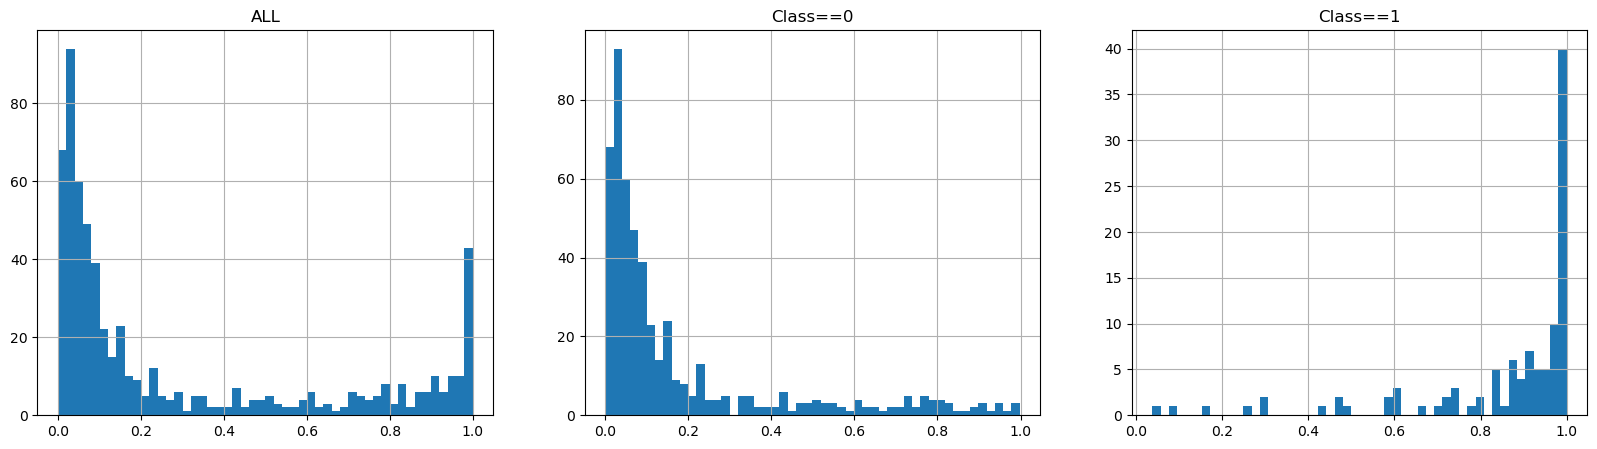

####################################################################################################
CV repeat nbr: 10 - metric: 0.3102


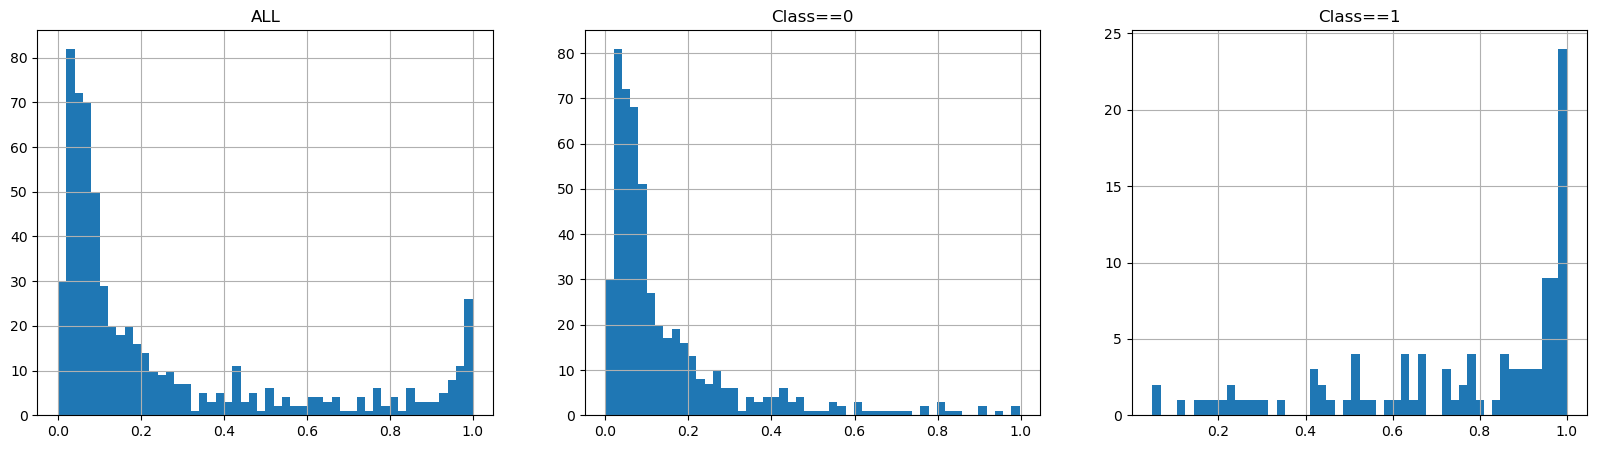

CV repeat nbr: 10 - metric: 0.2919


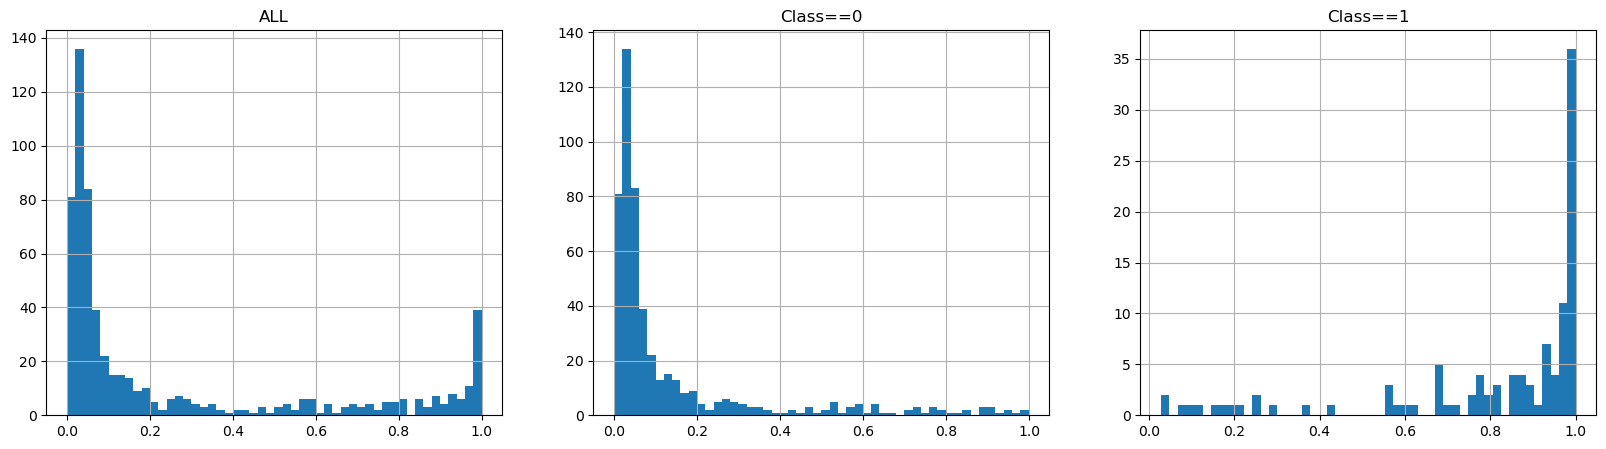

In [16]:
for i,oof in enumerate(oof_dfs):
    print("#"*100)
    oof = oof.copy()
    
    metric = balanced_logloss_(oof.pred_proba.values, oof.Class.values)
    print(f"CV repeat nbr: {i+1} - metric: {metric:0.4f}")

    plt.figure(figsize=(20,5))

    plt.subplot(1,3,1)
    plt.title("ALL")
    oof.pred_proba.hist(bins=50)

    plt.subplot(1,3,2)
    plt.title("Class==0")
    oof.query("Class==0").pred_proba.hist(bins=50)

    plt.subplot(1,3,3)
    plt.title("Class==1")
    oof.query("Class==1").pred_proba.hist(bins=50)

    plt.show()
    
    calib_p1 = calibrate_probs(
        oof.pred_proba.values,
        **calib_params
    )
    oof["pred_proba"] = calib_p1
    
    metric = balanced_logloss_(oof.pred_proba.values, oof.Class.values)
    print(f"CV repeat nbr: {i+1} - metric: {metric:0.4f}")

    plt.figure(figsize=(20,5))

    plt.subplot(1,3,1)
    plt.title("ALL")
    oof.pred_proba.hist(bins=50)

    plt.subplot(1,3,2)
    plt.title("Class==0")
    oof.query("Class==0").pred_proba.hist(bins=50)

    plt.subplot(1,3,3)
    plt.title("Class==1")
    oof.query("Class==1").pred_proba.hist(bins=50)

    plt.show()

***
# inference

In [17]:
predicted_probs = [
    model.predict(test[input_cols].values, verbose=0)[0][:,1:].sum(axis=1)
    for model in models
]
predicted_probs = np.mean(predicted_probs, axis=0)
predicted_probs

array([0.7321904, 0.7321904, 0.7321904, 0.7321904, 0.7321904],
      dtype=float32)

In [18]:
predicted_probs = calibrate_probs(predicted_probs, **calib_params)
predicted_probs = np.clip(predicted_probs, a_min=1e-7, a_max=1-1e-7)
predicted_probs

array([0.85269886, 0.85269886, 0.85269886, 0.85269886, 0.85269886],
      dtype=float32)

In [19]:
sub = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")
sub["class_0"] = 1-predicted_probs
sub["class_1"] = predicted_probs
sub.to_csv("submission.csv", index=False)
sub.describe()

,class_0,class_1
count,5.000000,5.000000
mean,0.147301,0.852699
std,0.000000,0.000000
min,0.147301,0.852699
25%,0.147301,0.852699
50%,0.147301,0.852699
75%,0.147301,0.852699
max,0.147301,0.852699


***
## save artifacts

In [20]:
joblib.dump(models, "models.pkl")
joblib.dump(oof_dfs, "oof_dataframes.pkl")
oof_scores.to_csv("oof_scores.csv", index=False)
joblib.dump(scaler, "scaler.pkl")
joblib.dump(calib_params, "calib_params.pkl")

['calib_params.pkl']

***